In [1]:
import sys
sys.path.insert(0, '/user/jericho/PyPPM')
from ppmpy.ppm import *
%matplotlib nbagg

In [2]:
set_YProf_path('/data/ppm_rpod2/YProfiles/O-shell-M25/')
D1=yprofile('D1')

<IPython.core.display.Javascript object>


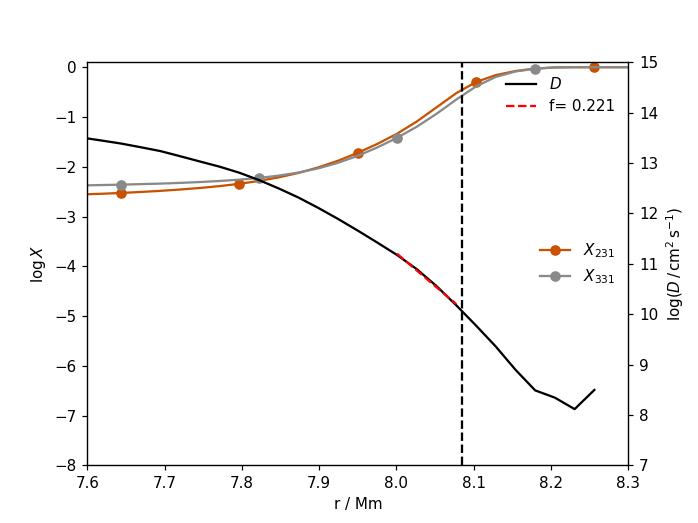

(7, 15)

In [6]:
D1.Dinv(231, 331, plot_Dlt0=False, approx_D = True, linelims = [8.,8.1],r0 = 6.3)
pl.xlim(7.6,8.3)
pl.ylim(7,15)

In [5]:
yprofile.Dinv?

# Using the function

In [ ]:

'''
Calculate and plot an exponentially decaying diffusion coefficient
given an r0, D0 and f.

Dov is given by the formula D0*exp(-2*(r-r0)/f*Hp)

Parameters
----------
r0 : float
    radius (Mm) at which the decay will begin
D0 : float
    diffusion coefficient at r0
f : float
    what f-value (parameter, where f*Hp is the e-folding length
    of the diffusion coefficient) should we decay with?
fname : int
    which dump do you want to take r and P from?

Output
------
r : array
    radial co-ordinates (Mm) for which we have a diffusion coefficient
    the decays exponentially
D : array
    Exponentially decaying diffusion coefficient (cm^2/s)
'''
#    Hp = 1 / d lnP/dr = P / (d)
r = self.get('Y',fname=fname,resolution='l')[::-1] * 1.e8  # cm, centre to surface
P = self.get('P',fname=fname)[::-1] * 1.e19 # barye, centre to surface
Hp = - P[1:] * np.diff(r) / np.diff(P)
Hp = np.insert(Hp,0,0)
idx = np.abs(r - r0*1.e8).argmin()
r0 = r[idx]
Hp0 = Hp[idx]

print r0, Hp0, idx

D = D0 * np.exp(-2. * (r[idx:] - r0) / f / Hp0)
f = (-2. * (r[idx:] - r0)) / np.log( (D[idx:]/D0) *Hp0

<IPython.core.display.Javascript object>


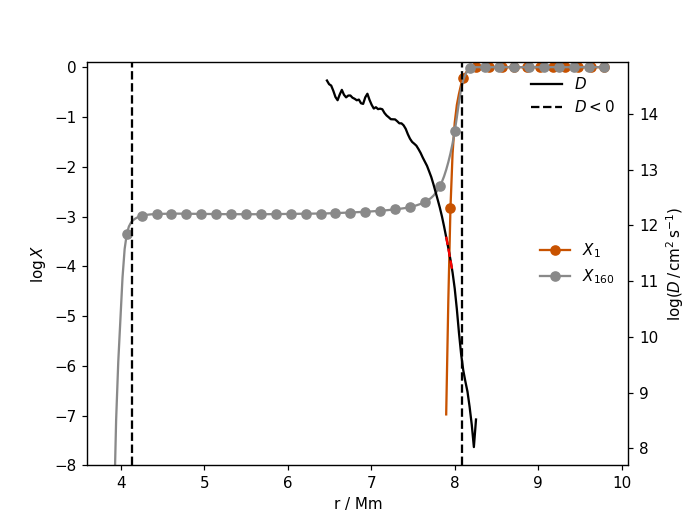

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:302: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:306: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:320: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:320: RuntimeWarning: invalid value encountered in log10


In [74]:
import numpy as np
prof = yprofile('/data/ppm_rpod2/YProfiles/O-shell-M25/D1')
fname1=1
fname2=160
fluid='FV H+He'
numtype='ndump'
newton=False
niter=3
debug=False
grid=False
FVaverage=False
tauconv=None

returnY=False
plot_Dlt0=True
silent = True
initial_conv_boundaries = True
approx_D=True
linelims=(7.9,8.)
linelabel=None
'''
Solve inverted diffusion equation to see what diffusion coefficient
profile would have been appropriate to mimic the mixing of species
seen in the Yprofile dumps.

In the present version, we only solve for D in the region where
'FV H+He' is not 0 or 1 in dump fname 2.

Parameters
----------
fname1,fname2 : int or float
    cycles from which to take initial and final abundance profiles
    for the diffusion step we want to mimic.
fluid : string
    Which fluid do you want to track?
numtype : string, optional
    Designates how this function acts and how it interprets
    fname.  If numType is 'file', this function will get the
    desired attribute from that file.  If numType is 'NDump'
    function will look at the cycle with that nDump.  If
    numType is 'T' or 'time' function will find the _cycle
    with the closest time stamp.
    The default is "ndump".
newton : boolean, optional
    Whether or not to apply Newton-Raphson refinement of the
    solution for D.
    The default is False
niter : int, optional
    If N-R refinement is to be done, niter is how many iterations
    to compute.
    The default is 3.
grid : boolean, optional
    whether or not to show the axes grids.
    The default is False.
FVaverage : boolean, optional
    Whether or not to average the abundance profiles over a
    convective turnover timescale. See also tauconv.
    The default is False.
tauconv : float, optional
    If averaging the abundance profiles over a convective turnover
    timescale, give the convective turnover timescale (seconds).
    The default value is None.
returnY : boolean, optional
    If True, return abundance vectors as well as radius and diffusion
    coefficient vectors
    The default is False.
plot_Dlt0 : boolean, optional
    whether or not to plot the diffusion coefficient when it is
    negative
approx_D : boolean, optional
    whether or not to plot an approximate diffusion coefficient 
    for an area of the line
linelims : range, optional
    limits of the radius to approximate diffusion coefficient
    default is none (whole vector)
linelabel : string, optional
    name for the approximation of D
    default is None

Output
------
x : array
    radial co-ordinates (Mm) for which we have a diffusion coefficient
D : array
    Diffusion coefficient (cm^2/s)

Example
-------
YY=ppm.yprofile(path_to_data)
YY.Dinv(1,640)
'''


xlong = prof.get('Y',fname=fname1,resolution='l') # for plotting
if debug: print xlong
x = xlong
x = x * 1.e8

def mf(fluid,fname):
    '''
    Get mass fraction profile of fluid 'fluid' at fname.
    '''
    y = prof.get(fluid,fname=fname,resolution='l')
    if fluid == 'FV H+He':
        rhofluid = prof.get('Rho H+He',fname=fname,resolution='l')
    else:
        rhofluid = prof.get('RHOconv',fname=fname,resolution='l')
    rho = prof.get('Rho',fname=fname,resolution='l')
    y = rhofluid * y / rho
    return y

if FVaverage is False:
    y1 = mf(fluid,fname2)
    y1long = y1 # for plotting

    y0 = mf(fluid,fname1)
    y0long = y0 # for plotting
else:
    if tauconv is None:
        raise IOError("Please define tauconv")
    # Find the dumps accross which one should average:
    # first profile:
    myt0 = prof.get('t',fname1)[-1]
    myt01 = myt0 - tauconv / 2.
    myt02 = myt0 + tauconv / 2.
    myidx01 = np.abs(prof.get('t') - myt01).argmin()
    myidx02 = np.abs(prof.get('t') - myt02).argmin()
    mycyc01 = prof.cycles[myidx01]
    mycyc02 = prof.cycles[myidx02]
    # second profile:
    myt1 = prof.get('t',fname2)[-1]
    myt11 = myt1 - tauconv / 2.
    myt12 = myt1 + tauconv / 2.
    myidx11 = np.abs(prof.get('t') - myt11).argmin()
    myidx12 = np.abs(prof.get('t') - myt12).argmin()
    mycyc11 = prof.cycles[myidx11]
    mycyc12 = prof.cycles[myidx12]
    # do the average for the first profile:
    ytmp = np.zeros(len(x))
    count=0
    for cyc in range(mycyc01,mycyc02):
        ytmp += mf(fluid,cyc)
        count+=1
    y0 = ytmp / float(count)
    # do the average for the first profile:
    ytmp = np.zeros(len(x))
    count=0
    for cyc in range(mycyc11,mycyc12):
        ytmp += mf(fluid,cyc)
        count+=1
    y1 = ytmp / float(count)

    y0long = y0
    y1long = y1

if fluid == 'FV H+He':
    y1 = y1[::-1]
    x = x[::-1]
    y0 = y0[::-1]

if debug: print len(xlong), len(y0long)

idx0 = np.abs(np.array(prof.cycles) - fname1).argmin()
idx1 = np.abs(np.array(prof.cycles) - fname2).argmin()
t0 = prof.get('t')[idx0]
t1 = prof.get('t')[idx1]
deltat = t1 - t0

# now we want to exclude any zones where the abundances
# of neighboring cells are the same. This is hopefully
# rare inside the computational domain and limited to only
# a very small number of zones
indexarray = np.where(np.diff(y1) == 0)[0]
if not silent:
    print 'removing zones:', indexarray
y1 = np.delete(y1,indexarray)
y0 = np.delete(y0,indexarray)
x = np.delete(x,indexarray)

# in the current formulation for the inner boundary condition,
# y1[0] != 0:
while y1[0] == 0.:
    x = x[1:]
    y0 = y0[1:]
    y1 = y1[1:]

# Try moving left boundary one over to allow for "exact"
# boundary condition and saving the now ghost cell value
xl = x[100]
y0l = y0[100]
y1l = y1[100]
x = x[101:]
y0 = y0[101:]
y1 = y1[101:]

if debug : print y0, y1, deltat
if not silent:
    print 'deltat = ', deltat, 's'
p = np.zeros(len(x))
q = np.zeros(len(x))

xdum = np.zeros(3) # our workhorse array for differencing

dt = float(deltat)

# calculate matrix elements for intermediate mesh points:
def matrixdiffus(x, y0, y1, dt):
    m = len(x) - 1
    for i in range(1,m):
        xdum[0] = x[i-1]
        xdum[1] = x[i]
        xdum[2] = x[i+1]

        xl = xdum[1] - xdum[0]
        xr = xdum[2] - xdum[1]

        xm = 0.5 * (xdum[2] - xdum[0])

        alpha = dt / xm

        p[i] = (y1[i] - y1[i-1]) * alpha / xl
        q[i] = (y1[i] - y1[i+1]) * alpha / xr

    # central (left) boundary:
    xdum[1] = x[0]
    xdum[2] = x[1]
    xr = xdum[2] - xdum[1]
    alpha = dt / (xr * xr)
#            p[0] = y1[i] * alpha
#            q[0] = (y1[i] - y1[i+1]) * alpha
#            p[0] = y1[0] * alpha
#            q[0] = (y1[0] - y1[1]) * alpha
    # Trying new boundary conditions:
    p[0] = (y1[0] - y1l) * alpha
    q[0] = (y1[0] - y1[1]) * alpha
    if not silent:
        print 'p0, q0 = ', p[0],q[0]

    # surface (right) boundary:
    xdum[0] = x[m-1]
    xdum[1] = x[m]
    xl = xdum[1] - xdum[0]
    alpha = dt / (xl * xl)
#            p[m] = (y1[i] - y1[i-1]) * alpha
#            q[m] = 0
    p[m] = (y1[m] - y1[m-1]) * alpha
    q[m] = 0.
    if not silent:
        print 'pm, qm = ', p[m],q[m]

    G = np.zeros([len(x),len(x)])

    # set up matrix:

    for i in range(len(x)):
        if not silent:
            print 'p[i] = ', p[i]
        G[i,i] = p[i]
        if debug : print G[i,i]
        if i != len(x)-1 :
            G[i,i+1] = q[i]
            if debug : print G[i,i+1]

    A = np.array( [ G[i,:] for i in range(len(x)) ] )
    if not silent:
        print A[0]
        print 'determinant = ', np.linalg.det(A)
    return A


# Direct solution (initial guess if moving on to do Newton-
# Raphson refinement:
A = matrixdiffus(x,y0,y1,dt)
B = y0 - y1
D = np.linalg.solve(A,B)

if newton:
    x0 = D
    xn = np.zeros(len(x0))
    xn = x0
    xnp1 = np.zeros(len(x0))
    J = np.linalg.inv(A) # Jacobian matrix
    # refinement loop:
    for i in range(1,niter+1):
        f = np.dot(A,xn) - B
        xnp1 = xn - np.dot(J,f)
        corr = np.abs(xnp1 - xn) / xn
        cmax = max(corr)
        cmin = min(corr)
        if not silent:
            print 'NEWTON: iter '+str(i)
            print 'max. correction = ', cmax
            print 'min. correction = ', cmin
        xn = xnp1

    D = xnp1

cb = utils.colourblind
lsty = utils.linestyle

pl.figure()
pl.plot(xlong,np.log10(y0long),\
        marker='o',
        color=cb(8),\
        markevery=lsty(1)[1],\
        label='$X_{'+str(fname1)+'}$')
pl.plot(xlong,np.log10(y1long),\
        marker='o',\
        color=cb(9),\
        markevery=lsty(2)[1],\
        label='$X_{'+str(fname2)+'}$')
#        pl.ylabel('$\log\,X$ '+fluid.replace('FV',''))
pl.ylabel('$\log\,X$ ')
pl.xlabel('r / Mm')
pl.ylim(-8,0.1)
pl.legend(loc='center right').draw_frame(False)
if grid:
    pl.grid()
pl.twinx()
pl.plot(x/1.e8,np.log10(D),'k-',\
        label='$D$') #'$D > 0$')
if initial_conv_boundaries:
        pl.axvline(prof.radbase,linestyle='dashed',color='k')
        pl.axvline(prof.radtop,linestyle='dashed',color='k')
if plot_Dlt0:
    pl.plot(x/1.e8,np.log10(-D),'k--',\
            label='$D < 0$')
pl.ylabel('$\log(D\,/\,{\\rm cm}^2\,{\\rm s}^{-1})$')
if approx_D:
    if linelims is not None:
        indx1 = np.abs(x/1.e8 - linelims[0]).argmin()
        indx2 = np.abs(x/1.e8 - linelims[1]).argmin()
        m,b = pyl.polyfit(x[indx1:indx2]/1.e8,np.log10(D[indx1:indx2]),1)
    else:
        m,b = pyl.polyfit(x/1.e8,np.log10(D),1)
        indx1 = 0;indx2 = -1
    pl.plot(x[indx1:indx2]/1.e8,m*x[indx1:indx2]/1.e8+b,linestyle='dashed',color='r',label=linelabel)
pl.legend(loc='upper right').draw_frame(False)


# Calculation

In [77]:
rr = prof.get('Y',fname=1,resolution='l')[::-1]
P = prof.get('P',fname=fname1)[::-1] * 1.e19 # barye, centre to surface
Hp = - P[1:] * np.diff(rr) / np.diff(P)
Hp = np.insert(Hp,0,0)
r0 = 6.3
idxhp = np.abs(rr - r0).argmin()
idx = np.abs(r - r0*1.e8).argmin()
Hp0 = Hp[idxhp]
D0 = D[idx]
f = (-2. * np.abs(np.mean(x[indx1:indx2])/1.e8 - r0))\
/( np.log( (np.mean(D[indx1:indx2]))/D0) *Hp0)

print r0, Hp0, idxhp, f , D0, D[indx1]

6.3 1.69444361494 246 0.27449904866 3.95995546305e+14 613382666175.0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until
